# 1 - Exploration et préparation des données : qualité du vin rouge portugais

Ce notebook a pour objectif de préparer le jeu de données *Vinho Verde* afin de modéliser et prédire la qualité des vins rouges portugais.  
Nous procédons à une étude complète en suivant les étapes clés de l'analyse de données supervisée et non supervisée, en nous appuyant sur les outils du cours SY09 (ACP, clustering, normalisation...).

L'ensemble des opérations réalisées comprend :

- l’exploration initiale des variables (types, valeurs),
- le nettoyage des données (valeurs manquantes, doublons),
- la mise à l’échelle des variables quantitatives,
- le regroupement de la variable cible `quality`,
- des approches non supervisées (K-means, PCA),

## Sommaire

- [1-Compréhension des variables](#1-compréhension-des-variables)  
  - [a. Chargement des données](#a-chargement-des-données)  
  - [b. Aperçu du jeu de données](#b-aperçu-du-jeu-de-données)  
  - [c. Types des variables](#c-types-des-variables)  
- [2-Nettoyage des données](#2-nettoyage-des-données)  
  - [a. Suppression des valeurs manquantes](#a-suppression-des-valeurs-manquantes)  
  - [b. Suppressions des doublons](#b-suppressions-des-doublons)  
  - [c. Normalisation des features](#c-normalisation-des-features)  
- [Regroupement de la variable quality](#regroupement-de-la-variable-quality)  
  - [a. Visualisation](#a-visualisation)  
  - [b. Approche non supervisée : identifier des groupes naturels](#b-approche-non-supervisée--identifier-des-groupes-naturels)


## 0 - Installation des librairies
---
Au cours de ce notebook, nous utilisons différentes fonctions ou classes venant de librairies non implémentées directement dans Python. Pour le bon fonctionnement de l'ensemble des cellules présentant du code, les importations ci-dessous sont nécessaires.

In [250]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, Index
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

## 1-Compréhension des variables

Dans cette section, nous identifions les variables quantitatives et qualitatives présentes dans le jeu de données. Cela nous permet de mieux comprendre la structure des données et de planifier les étapes suivantes de l'analyse.

### a. Chargement des données

Ce jeu de données est lié aux variantes rouges du vin portugais \"Vinho Verde\". Il décrit la quantité de divers composés chimiques présents dans le vin et leur effet sur sa qualité. 

#### Lien vers le dataset :
[Wine Quality Dataset (Kaggle)](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset?select=WineQT.csv)

In [251]:
# Chargement des données
path: str = os.path.join(os.path.dirname(
    os.getcwd()), "data", 'WineQT.csv')
data: pd.DataFrame = pd.read_csv(path, index_col='Id')

### b. Aperçu du jeu de données

In [252]:
# Informations générales
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1143 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 116.1 KB


In [253]:
# Aperçu des données
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [254]:
# Statistiques descriptives
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Ce jeu de données comporte 1143 individus (ici des vins rouges) décrites par 12 variables. Une treizième variable existe, mais représente les ID des vins, cela représentera donc l'index des individus.

### c. Types des variables

In [255]:
# Types de variables
quantitative_vars: list[str] = data.select_dtypes(
    include=['float64', 'int64']).columns.tolist()
print("Variables quantitatives :", quantitative_vars)
qualitative_vars: list[str] = data.select_dtypes(
    include=['object']).columns.tolist()
print("Variables qualitatives :", qualitative_vars)

Variables quantitatives : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Variables qualitatives : []


Dans ce dataset, nous avons uniquement des variables quantitatives. Cela représente un avantage, puisque la grande majorité des analyses de données sont prévues pour de telles variables (PCA, Classification, ...)

## 2-Nettoyage des données

---

### a. Suppression des valeurs manquantes

In [256]:
# Vérification des valeurs manquantes
missing_values: pd.Series = data.isnull().sum()
missing_columns: pd.Series = missing_values[missing_values > 0]

if not missing_columns.empty:
    print("Colonnes avec des valeurs manquantes :")
    for col, count in missing_columns.items():
        print(f"- {col} : {count} valeurs manquantes")

    # Suppression des lignes avec des valeurs manquantes
    initial_count: int = len(data)
    data: pd.DataFrame = data.dropna()
    final_count: int = len(data)
    print(f"{initial_count - final_count} lignes supprimées en raison de valeurs manquantes.")
else:
    print("Aucune valeur manquante détectée.")

Aucune valeur manquante détectée.


### b. Suppressions des doublons

In [257]:
# Doublons
if data.duplicated().sum() > 0:
    print(f"Doublons trouvés : {data.duplicated().sum()} lignes suprimées.")
    # Suppression des doublons
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
else:
    print("Aucun doublon trouvé.")

Doublons trouvés : 125 lignes suprimées.


### c. Normalisation des features

La normalisation est nécessaire pour mettre toutes les variables sur la même échelle afin d’éviter qu’une variable comme l’alcool, avec une amplitude plus grande, ne domine les autres dans les méthodes sensibles aux distances comme l’ACP ou le K-means. Tout d'abord, nous visualisons les données sans normalisation.

In [258]:
# Sauvegarde de l'index Id
ids: Index = data.index.copy()

# Sélection des variables quantitatives (hors quality et Id si présent)
features: List[str] = data.drop(columns=["quality", "Id"], errors='ignore') \
    .select_dtypes(include=['float64', 'int64']).columns.tolist()

# Sous-ensemble des features
data_features: DataFrame = data[features]

# Normalisation avec StandardScaler
scaler: StandardScaler = StandardScaler()
data_normalized: DataFrame = pd.DataFrame(
    scaler.fit_transform(data_features),
    columns=features,
    index=ids  # pour garder la correspondance avec l’index d’origine
)

**Données avant la normalisation:**

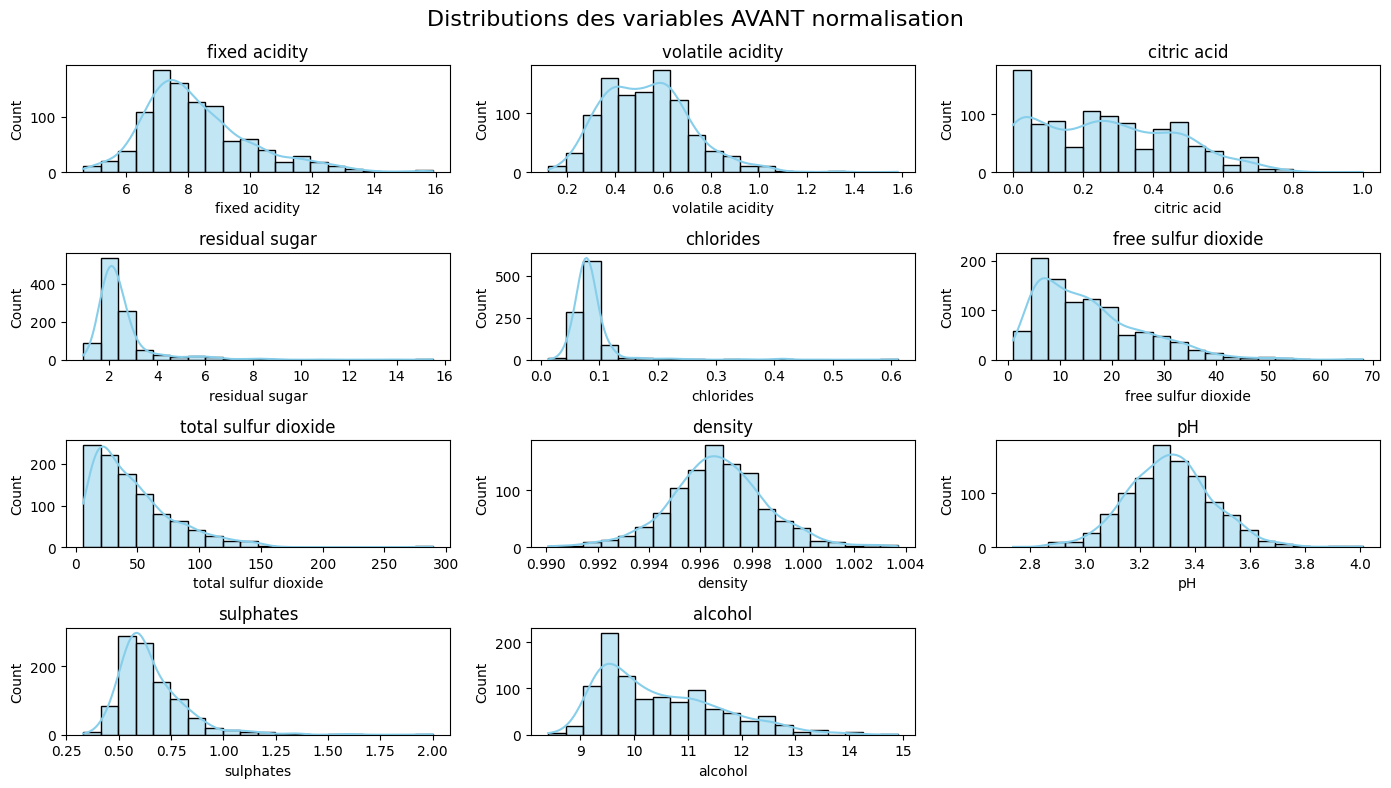

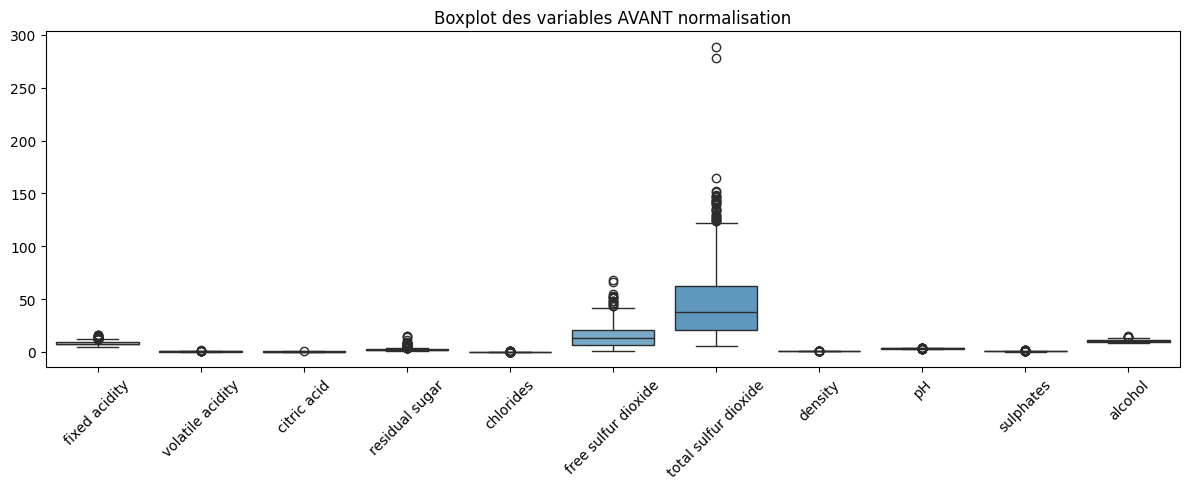

In [259]:
# Histoplot avant normalisation
plt.figure(figsize=(14, 8))
for i, column in enumerate(data_features.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data_features[column], bins=20,
                 kde=True, color="skyblue", edgecolor="black")
    plt.title(column)
plt.suptitle("Distributions des variables AVANT normalisation", fontsize=16)
plt.tight_layout()
plt.show()

# Boxplot avant normalisation
plt.figure(figsize=(12, 5))
sns.boxplot(data=data_features, palette="Blues")
plt.title("Boxplot des variables AVANT normalisation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les histogrammes montrent que certaines variables comme `alcohol`, `residual sugar` ou `total sulfur dioxide` ont des échelles de valeurs beaucoup plus grandes que d'autres comme `chlorides` ou `sulphates`.

Les boxplots confirment cette hétérogénéité : les amplitudes diffèrent fortement d'une variable à l'autre, ce qui pourrait biaiser les analyses basées sur la distance (comme l’ACP ou les clusters).
Certaines variables montrent aussi des valeurs extrêmes (outliers), comme `total sulfur dioxide` ou `residual sugar`.

Pour régler cela, nous utilisons le `StandardScaler` de la librairie `sklearn`. Celui-ci normalise simplement les variables $p_i$ grâce au TCL : $$p_{i_{\text{normalisé}}} = \frac{p_i - \mathbb{E}(p_i)}{\sqrt{\text{Var}(p_i)}}$$

**Données après la normalisation:**

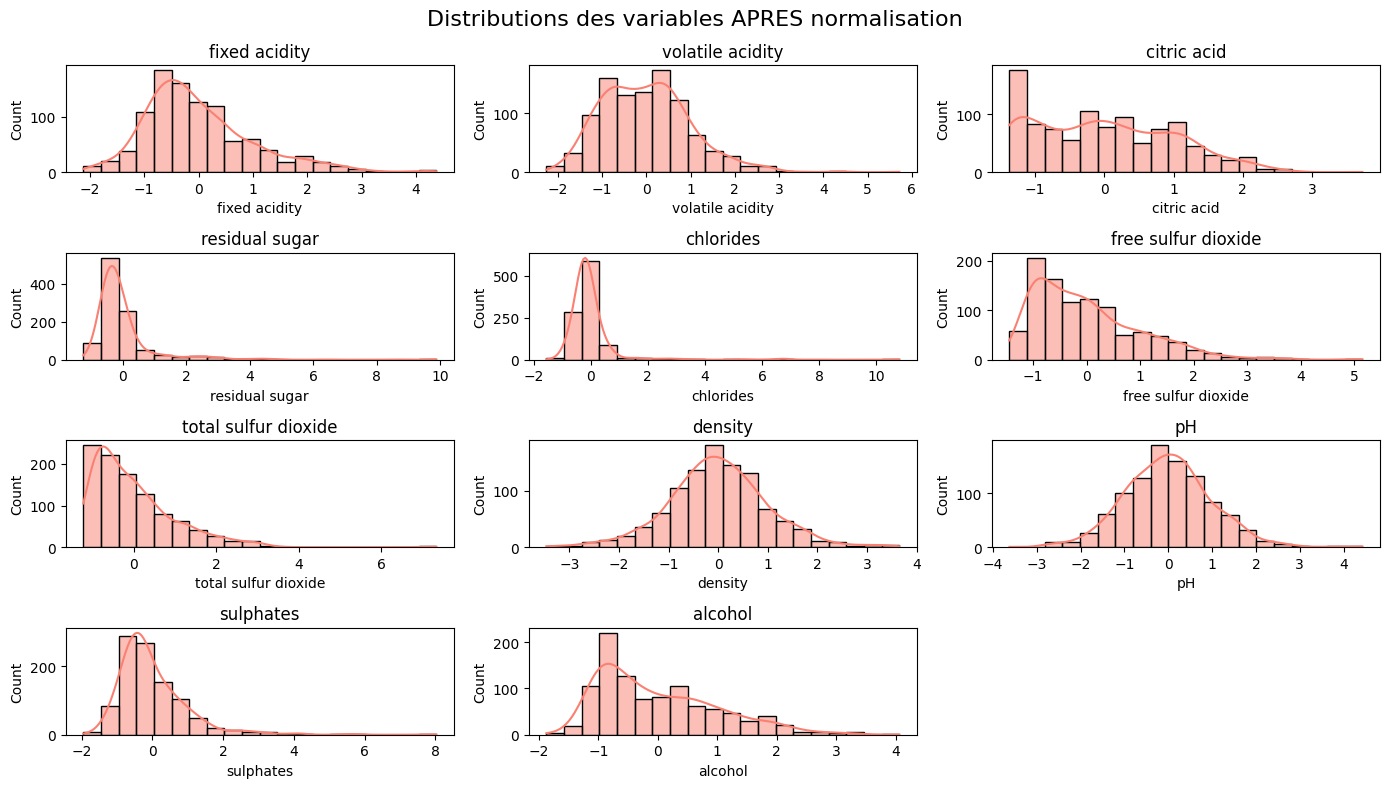

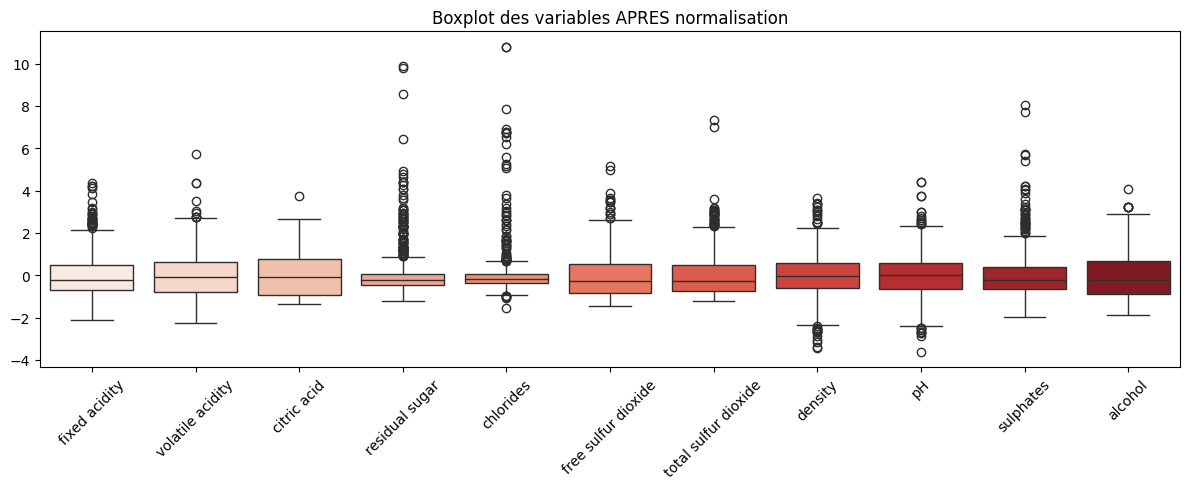

In [260]:
# Histoplot avant normalisation
plt.figure(figsize=(14, 8))
for i, column in enumerate(data_normalized.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data_normalized[column], bins=20,
                 kde=True, color="salmon", edgecolor="black")
    plt.title(column)
plt.suptitle("Distributions des variables APRES normalisation", fontsize=16)
plt.tight_layout()
plt.show()

# Boxplot avant normalisation
plt.figure(figsize=(12, 5))
sns.boxplot(data=data_normalized, palette="Reds")
plt.title("Boxplot des variables APRES normalisation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Après normalisation, toutes les variables ont une distribution centrée autour de 0 avec un écart-type d’environ 1 (ce qui correspond à la distribution d'une loi normale centrée réduite). Cela rend les variables comparables, indépendamment de leur unité ou échelle initiale.

Les boxplots montrent des amplitudes similaires entre toutes les variables, ce qui est essentiel pour appliquer des méthodes sensibles à l’échelle comme l’ACP, la K-means, ou les algorithmes à base de distances.  
Les valeurs extrêmes sont conservées mais deviennent moins influentes dans les calculs.
Les données originales sont remplacées par les données normalisées par le `StandardScaler` dans le DataFrame

In [261]:
# Mise à jour du DataFrame avec les données normalisées
data[features] = data_normalized[features]
# On s'assure que l'index est bien "Id"
data.index.name = "Id"
# Vérification
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,-0.510499,0.909227,-1.370507,-0.475125,-0.230739,-0.457043,-0.372294,0.574517,1.258719,-0.578153,-0.961563,5
1,-0.280676,1.892418,-1.370507,0.057517,0.223040,0.919349,0.624466,0.052448,-0.707068,0.138438,-0.596108,5
2,-0.280676,1.236957,-1.166564,-0.170758,0.099282,-0.063788,0.231803,0.156862,-0.326593,-0.040710,-0.596108,5
3,1.672822,-1.384886,1.484700,-0.475125,-0.251365,0.132839,0.413032,0.678931,-0.960718,-0.458721,-0.596108,6
4,-0.510499,0.690740,-1.370507,-0.551216,-0.251365,-0.260415,-0.191065,0.574517,1.258719,-0.578153,-0.961563,5


In [262]:
# Sauvegarde du DataFrame normalisé
data.to_csv(os.path.join(os.path.dirname(
    os.getcwd()), "data", 'WineQT_normalized.csv'), index=True)

## 3. Regroupement de la variable quality

---

La variable `quality` représente une note attribuée aux vins (entre 0 et 10). Cependant, cette note :
- est **discrète** et **centrée** autour de valeurs moyennes (notamment 5, 6 et 7),
- semble issue d’un **vote ou jugement subjectif** (rarement extrême: seul les variables allant de 3 à 8 sont présentes),
- n'est pas répartie uniformément.

Nous explorons ici différentes approches pour **justifier ou affiner un regroupement en classes**, à travers :
- des visualisations,
- du clustering non supervisé (K-means),
- l’étude de la distribution empirique (quantiles),
- la méthode du coude et du score de silhouette.

### a. Visualisation

#### Histogramme des notes

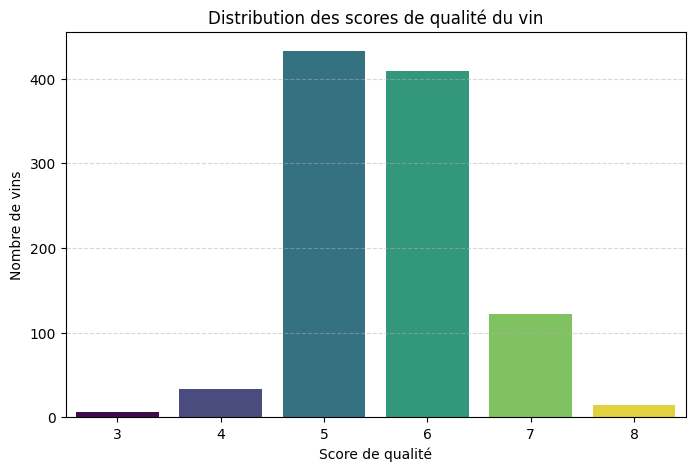

In [263]:
plt.figure(figsize=(8, 5))
sns.countplot(x="quality", data=data, hue="quality",
              palette="viridis", legend=False)
plt.title("Distribution des scores de qualité du vin")
plt.xlabel("Score de qualité")
plt.ylabel("Nombre de vins")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

**Analyse** :

- Distribution fortement asymétrique : les scores sont concentrés autour de 5 et 6.

- Les scores extrêmes (3, 4, 7, 8) sont très peu représentés.

- Cela confirme une distribution centrée autour d’un mode, avec une faible dispersion.

**Interprétation statistique** :

- On a une faible variance inter-classes si on prend toutes les valeurs telles quelles (peu d’écart entre 5 et 6).

- Le regroupement naturel serait donc :

    - **Classe basse** : 3–4

    - **Classe moyenne** : 5–6 (le cœur de la distribution)

    - **Classe haute** : 7–8

**Ce regroupement respecte la logique d’une classification supervisée : on augmente la séparation entre groupes en maximisant l’inertie inter-classes.**



#### Courbe de densité (KDE)

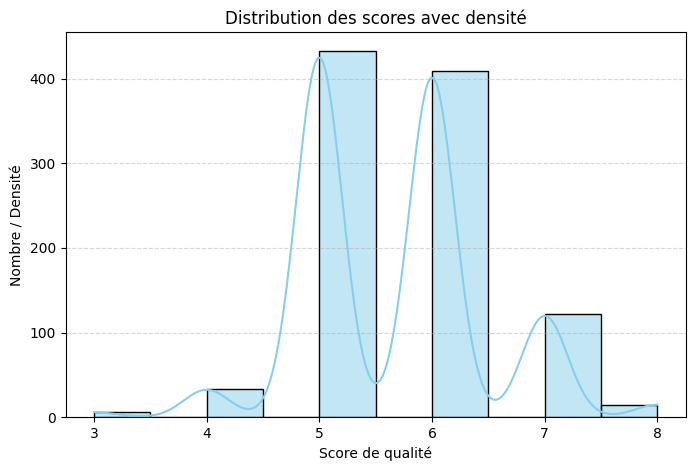

In [264]:
plt.figure(figsize=(8, 5))
sns.histplot(data['quality'], bins=10, kde=True, color='skyblue')
plt.title("Distribution des scores avec densité")
plt.xlabel("Score de qualité")
plt.ylabel("Nombre / Densité")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

**Analyse** :

- Deux pics nets à 5 et 6, avec une légère bosse à 7.

- Cela suggère que la variable n’est pas continue : ce sont des scores arrondis, pas des mesures continues (comme le pH par exemple).

- Le KDE montre bien une structure à 2 ou 3 pics, renforçant l’idée de regrouper.

**Implication** :

- Un regroupement en 2 classes (5-6 vs le reste) serait statistiquement possible, mais pas très informatif.

- Trois classes semblent mieux refléter la densité naturelle.

#### Courbe de répartition cumulative + seuils

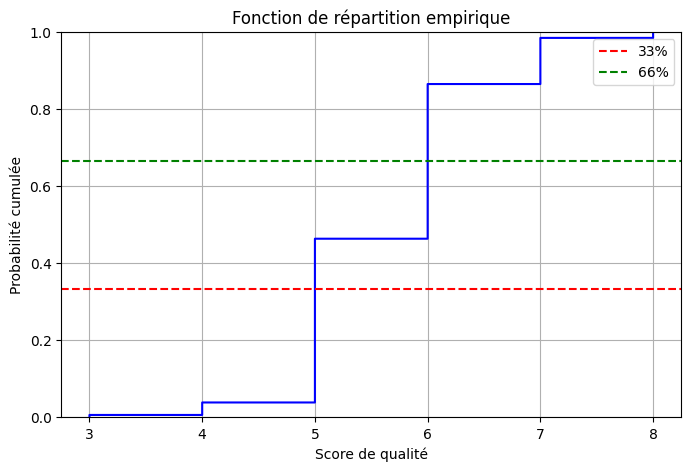

Seuils quantiles 33% / 66% :
0.33    5.0
0.66    6.0
Name: quality, dtype: float64


In [265]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(data["quality"], color="blue")
plt.axhline(1/3, linestyle="--", color="red", label="33%")
plt.axhline(2/3, linestyle="--", color="green", label="66%")
plt.title("Fonction de répartition empirique")
plt.xlabel("Score de qualité")
plt.ylabel("Probabilité cumulée")
plt.legend()
plt.grid(True)
plt.show()

# Affichage des quantiles
print("Seuils quantiles 33% / 66% :")
print(data["quality"].quantile([0.33, 0.66]))

**Interpretations**
- Cela correspond parfaitement à un regroupement ternaire équilibré :

    - Qualité faible : ≤ 5

    - Qualité moyenne : = 6

    - Qualité élevée : ≥ 7
- Cette répartition améliore l'equilibre entre les classes, ce qui est souvent utile pour l’apprentissage supervisé (voir le diagramme ci-dessous)

Avantage : Ce seuil basé sur les quantiles optimise l’égalité des classes.
Limite : La valeur 6 étant centrale, elle peut appartenir à une classe moyenne ou élevée, selon la stratégie.

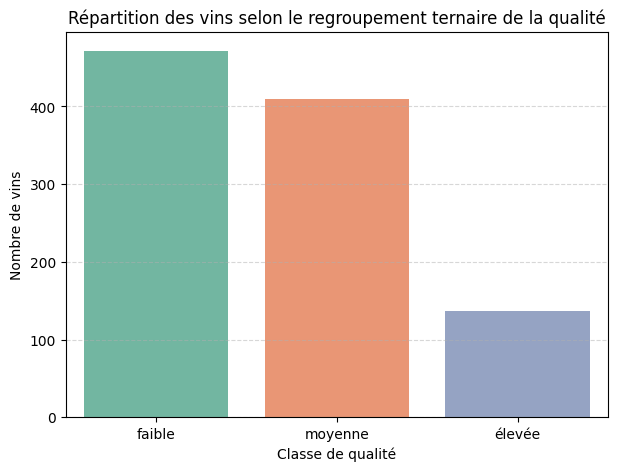

quality_group
faible     472
moyenne    409
élevée     137
Name: count, dtype: int64


In [266]:
# Regroupement en 3 classes basé sur les quantiles
def assign_quality_group(quality: int) -> str:
    if quality <= 5:
        return "faible"
    elif quality == 6:
        return "moyenne"
    else:  # quality >= 7
        return "élevée"


data["quality_group"] = data["quality"].apply(assign_quality_group)

# Affichage des effectifs par classe
plt.figure(figsize=(7, 5))
sns.countplot(x="quality_group", data=data, hue="quality_group", legend=False,
              palette="Set2", order=["faible", "moyenne", "élevée"])
plt.title("Répartition des vins selon le regroupement ternaire de la qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre de vins")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Affichage des effectifs (en complément)
print(data["quality_group"].value_counts())

### b. Approche non supervisée : identifier des groupes naturels

Avant de choisir arbitrairement un regroupement, on peut explorer si les données forment **naturellement des groupes homogènes**.

Pour cela, nous appliquons :
- une **standardisation** des données,
- un **clustering par K-means**,
- une analyse de la **courbe du coude** (inertie),
- une analyse du **score de silhouette**.

Ces outils nous aident à choisir **le nombre optimal de classes**.

#### K-means + coude + silhouette

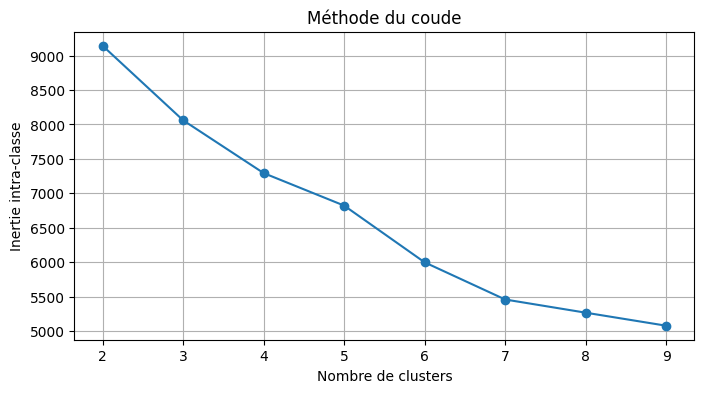

In [267]:
# Préparation des données
X: pd.DataFrame = data.select_dtypes(include=["int64", "float64"])
#!Warning: X has to be normalized
X = X.drop(columns=["quality", "quality_group",
           "quality_encoded", "Id"], errors='ignore')

# Tests pour différents k
inertias: list[float] = []
silhouettes: list[float] = []
K_range: range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X, labels))

# Courbe du coude
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra-classe")
plt.grid(True)
plt.show()

**Observation** :

- Le coude le plus visible est à k = 3 ou k = 6 (coude très léger).

- Après k = 3, la baisse de l’inertie devient plus faible → gain marginal pour chaque cluster supplémentaire.

**Conclusion**:

- Le coude est un critère d’optimisation de l’inertie intra-classe.

- Cela valide statistiquement l’hypothèse d’un regroupement en 3 clusters naturels, compatible avec :

    - la densité de la distribution,

    - les quantiles,

    - la sémantique métier (bas / moyen / haut).

- Si nous gardons k=6 cela signifie que nous gardons les données initiales sans les regrouper

#### Projection PCA avec clusters

Nous allons commencer par définir le nombre de composantes principales sur lesquelles nous allons faire une projection, en créant un diagramme montrant la variance expliquée et l'inertie cumulée par composante principale.

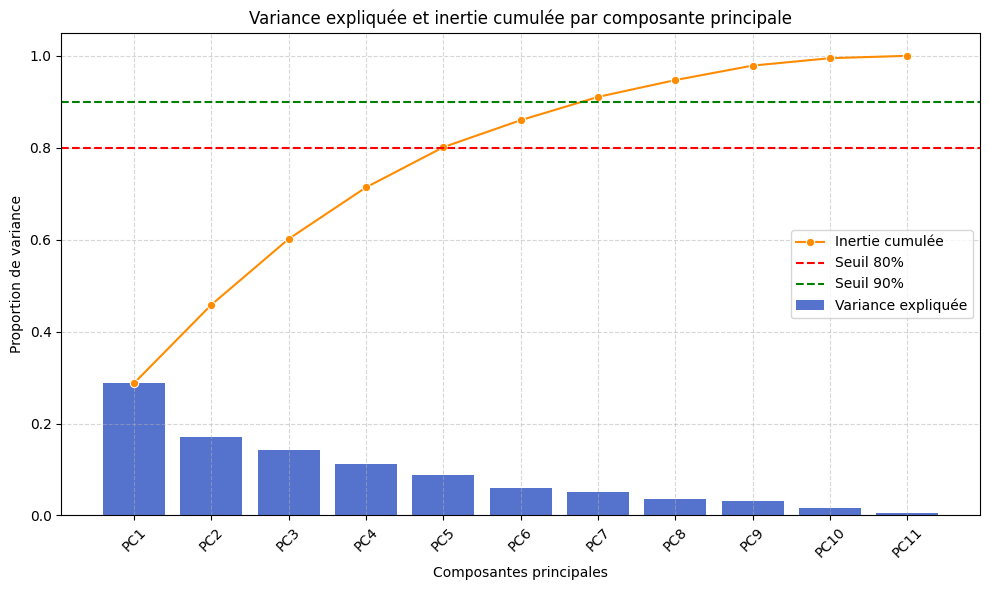

In [268]:
# Génération du diagramme complet avec toutes les composantes principales

# Recalcule des composantes principales si besoin
pca = PCA()
#!Warning: X has to be normalized
X_pca = pca.fit_transform(X)

# Extraction de l'inertie expliquée (variance)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_cumsum = explained_variance_ratio.cumsum()

# Création de la figure combinée
plt.figure(figsize=(10, 6))

# Barres : variance expliquée par chaque composante
sns.barplot(x=[f"PC{i+1}" for i in range(len(explained_variance_ratio))],
            y=explained_variance_ratio,
            color='royalblue',
            label="Variance expliquée")

# Courbe : inertie cumulée
sns.lineplot(x=range(len(explained_variance_cumsum)),
             y=explained_variance_cumsum,
             marker='o',
             color='darkorange',
             label="Inertie cumulée")

# Réglages esthétiques
plt.axhline(y=0.80, color='red', linestyle='--', label="Seuil 80%")
plt.axhline(y=0.90, color='green', linestyle='--', label="Seuil 90%")
plt.title("Variance expliquée et inertie cumulée par composante principale")
plt.xlabel("Composantes principales")
plt.ylabel("Proportion de variance")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Nous allons donc effectuer :

1. Une projection des individus sur 2 composantes principales (ce qui nous permettra de facilement visualiser les données et d'identifier les groupes naturels).

2. Une projection sur 5 composantes principales, qui couvrent environ 80 % de la variance totale.

Pour chacune des projections, nous allons visualiser le résultat avec 3 et 6 clusters pour nous aider à prendre une décision sur le regroupement.

Cela permet :

- d’évaluer la qualité de la représentation des individus,
- d'observer les séparations potentielles entre classes (par qualité ou clusters),
- de décider si une réduction de dimension à 2 composantes est suffisante pour une visualisation ou une modélisation.

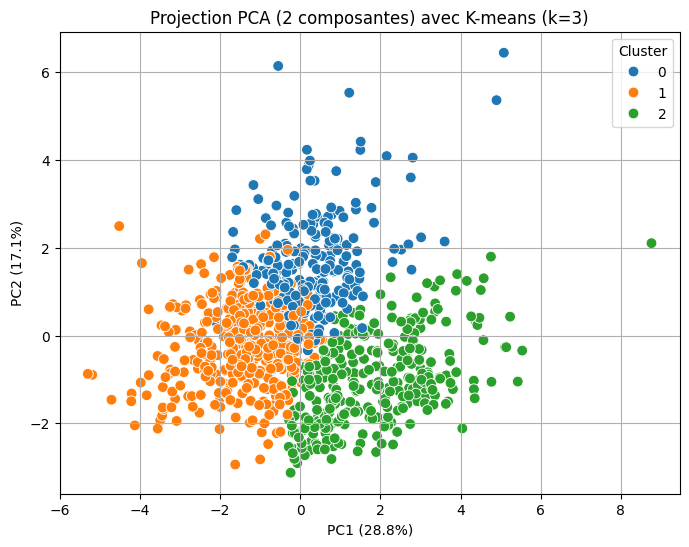

In [269]:
# Projetction PCA avec 2 composantes principales et K=3

pca_2 = PCA(n_components=2)
#!Warning: X has to be normalized
X_pca_2: pd.DataFrame = pca_2.fit_transform(X)

# K-means avec k=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_3: list[int] = kmeans_3.fit_predict(X)

# Visualisation
df_plot = pd.DataFrame(X_pca_2, columns=["PC1", "PC2"])
df_plot["cluster"] = labels_3

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2",
                hue="cluster", palette="tab10", s=60)
plt.title("Projection PCA (2 composantes) avec K-means (k=3)")
plt.xlabel(f"PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

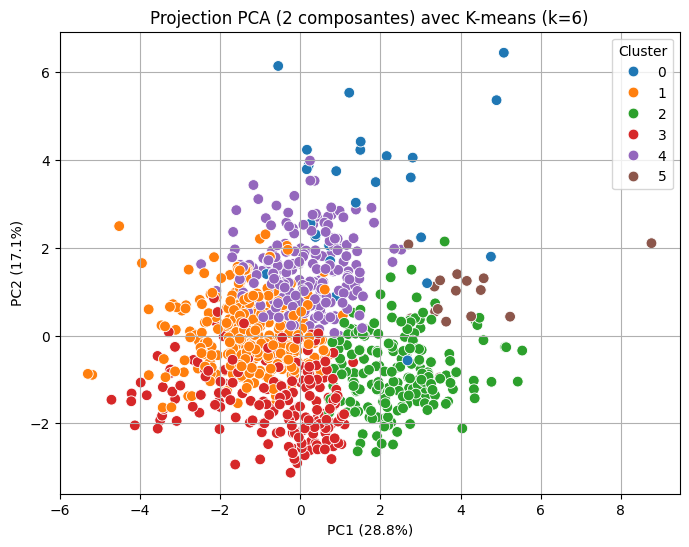

In [270]:
# Projection PCA avec 2 composantes principales et K=6

# K-means avec k=6
kmeans_6 = KMeans(n_clusters=6, random_state=42)
#!Warning: X has to be normalized
labels_6: list[int] = kmeans_6.fit_predict(X)

# Visualisation
df_plot = pd.DataFrame(X_pca_2, columns=["PC1", "PC2"])
df_plot["cluster"] = labels_6

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2",
                hue="cluster", palette="tab10", s=60)
plt.title("Projection PCA (2 composantes) avec K-means (k=6)")
plt.xlabel(f"PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

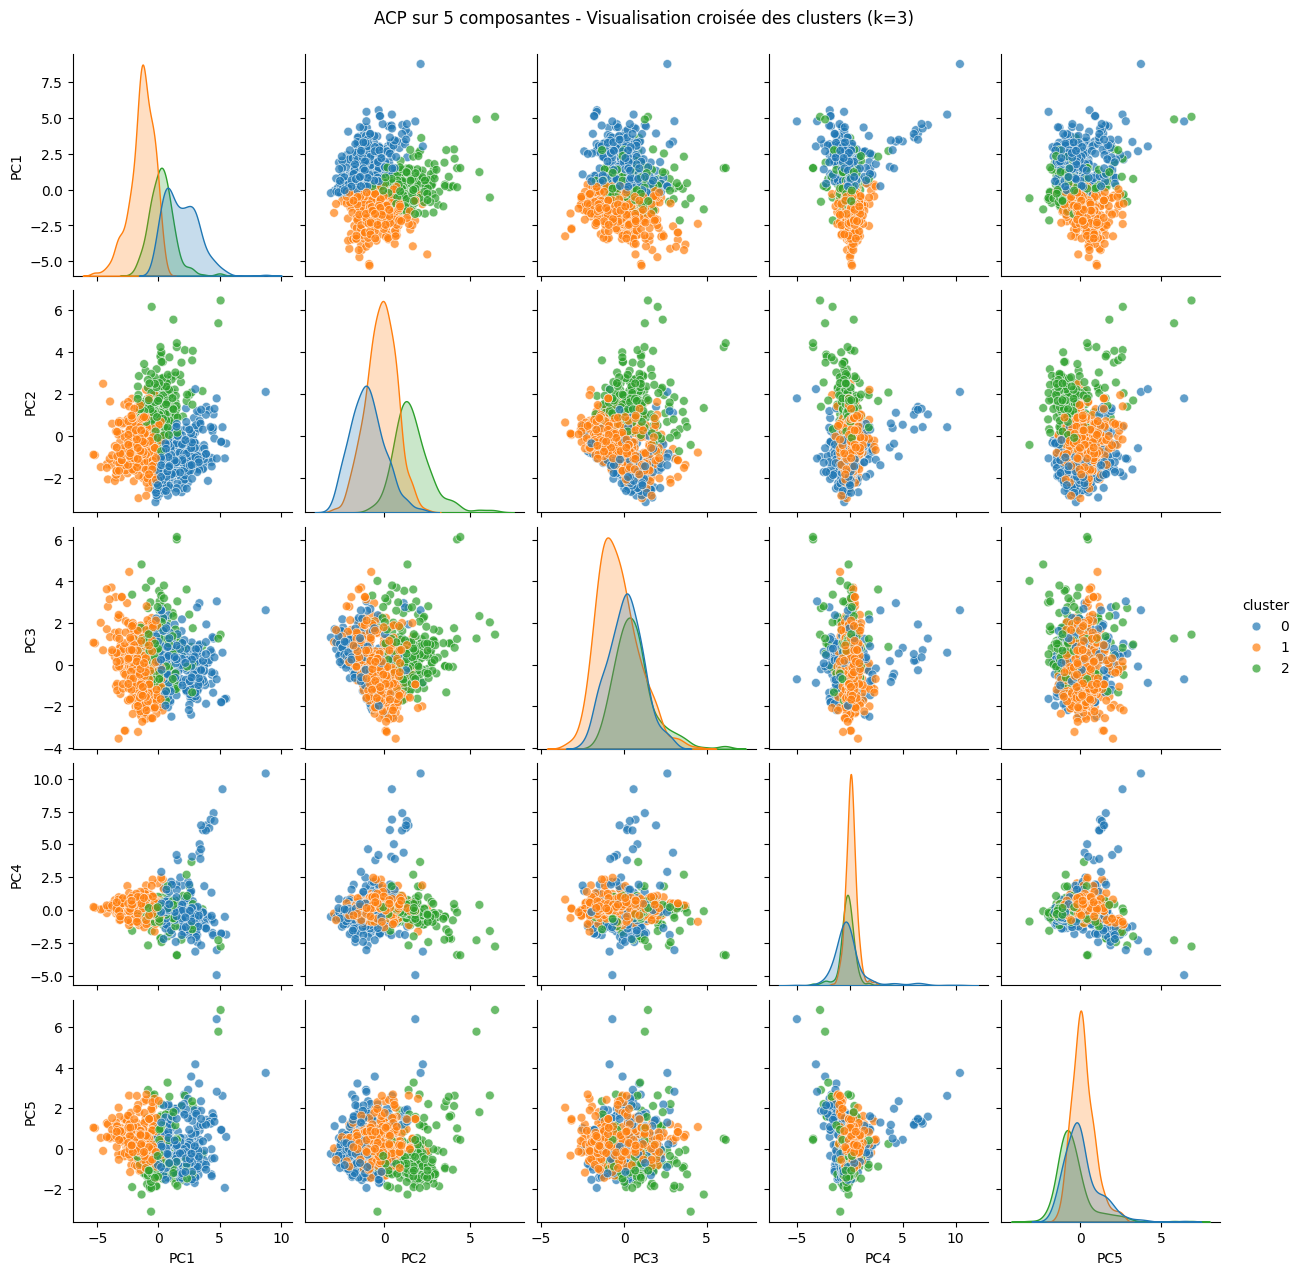

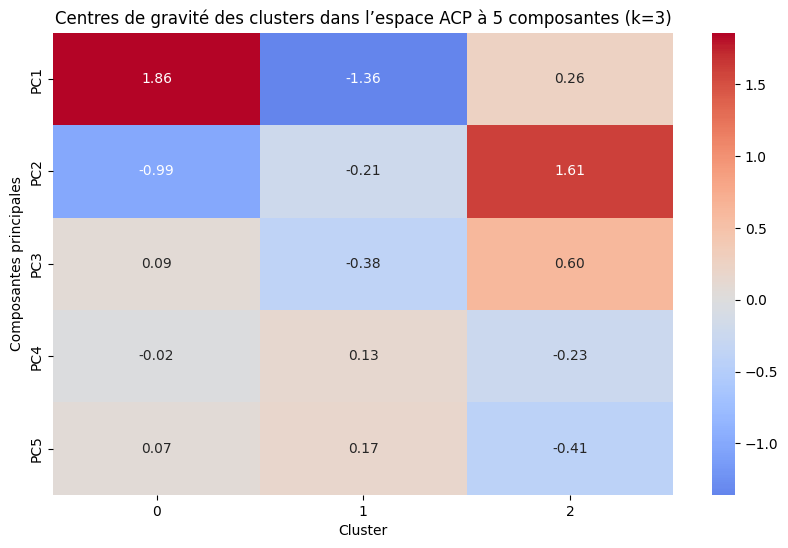

Inertie intra-classe moyenne du cluster 0 : 8.286
Inertie intra-classe moyenne du cluster 1 : 4.148
Inertie intra-classe moyenne du cluster 2 : 5.606

Inertie inter-classe      : 3125.53
Inertie intra-classe totale : 5846.29
Inertie totale              : 8971.82
Taux d'inertie expliquée    : 34.84%


In [271]:
# Projection PCA avec 5 composantes principales et K=3
# ACP à 5 composantes
pca_5 = PCA(n_components=5)
#!Warning: X has to be normalized
X_pca_5: pd.DataFrame = pca_5.fit_transform(X)

# K-means avec k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters: list[int] = kmeans.fit_predict(X_pca_5)

# Construction du dataframe pour le pairplot
df_pca_pairplot = pd.DataFrame(X_pca_5, columns=[f"PC{i+1}" for i in range(5)])
df_pca_pairplot["cluster"] = clusters

# Affichage
sns.pairplot(df_pca_pairplot, hue="cluster", palette="tab10",
             plot_kws={'alpha': 0.7, 's': 40})
plt.suptitle(
    f"ACP sur 5 composantes - Visualisation croisée des clusters (k={k})", y=1.02)
plt.show()

# Moyennes des composantes principales par cluster
df_means = df_pca_pairplot.groupby("cluster").mean()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_means.T, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(
    f"Centres de gravité des clusters dans l’espace ACP à 5 composantes (k={k})")
plt.xlabel("Cluster")
plt.ylabel("Composantes principales")
plt.show()

# Calcul de l’inertie intra-classe manuellement
inertie_clusters = []
for i in range(k):
    cluster_points = X_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    inertie = np.mean(distances ** 2)
    inertie_clusters.append(inertie)

# Affichage des inerties intra-classe par cluster
for i, inertie in enumerate(inertie_clusters):
    print(f"Inertie intra-classe moyenne du cluster {i} : {inertie:.3f}")


# Centre global
global_center = np.mean(X_pca_5, axis=0)

# Inertie inter-classe
inertie_inter = 0.0
for i in range(k):
    cluster_points = X_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    nk = cluster_points.shape[0]
    inertie_inter += nk * np.sum((centroid - global_center) ** 2)

# Inertie totale
inertie_totale = np.sum(np.linalg.norm(X_pca_5 - global_center, axis=1) ** 2)

# Inertie intra totale (somme des intra par points)
inertie_intra = np.sum([np.sum(np.linalg.norm(X_pca_5[clusters == i] -
                       X_pca_5[clusters == i].mean(axis=0), axis=1) ** 2) for i in range(k)])

# Taux d'inertie expliquée
taux_explique = inertie_inter / inertie_totale

# Résultats
print(f"\nInertie inter-classe      : {inertie_inter:.2f}")
print(f"Inertie intra-classe totale : {inertie_intra:.2f}")
print(f"Inertie totale              : {inertie_totale:.2f}")
print(f"Taux d'inertie expliquée    : {taux_explique*100:.2f}%")

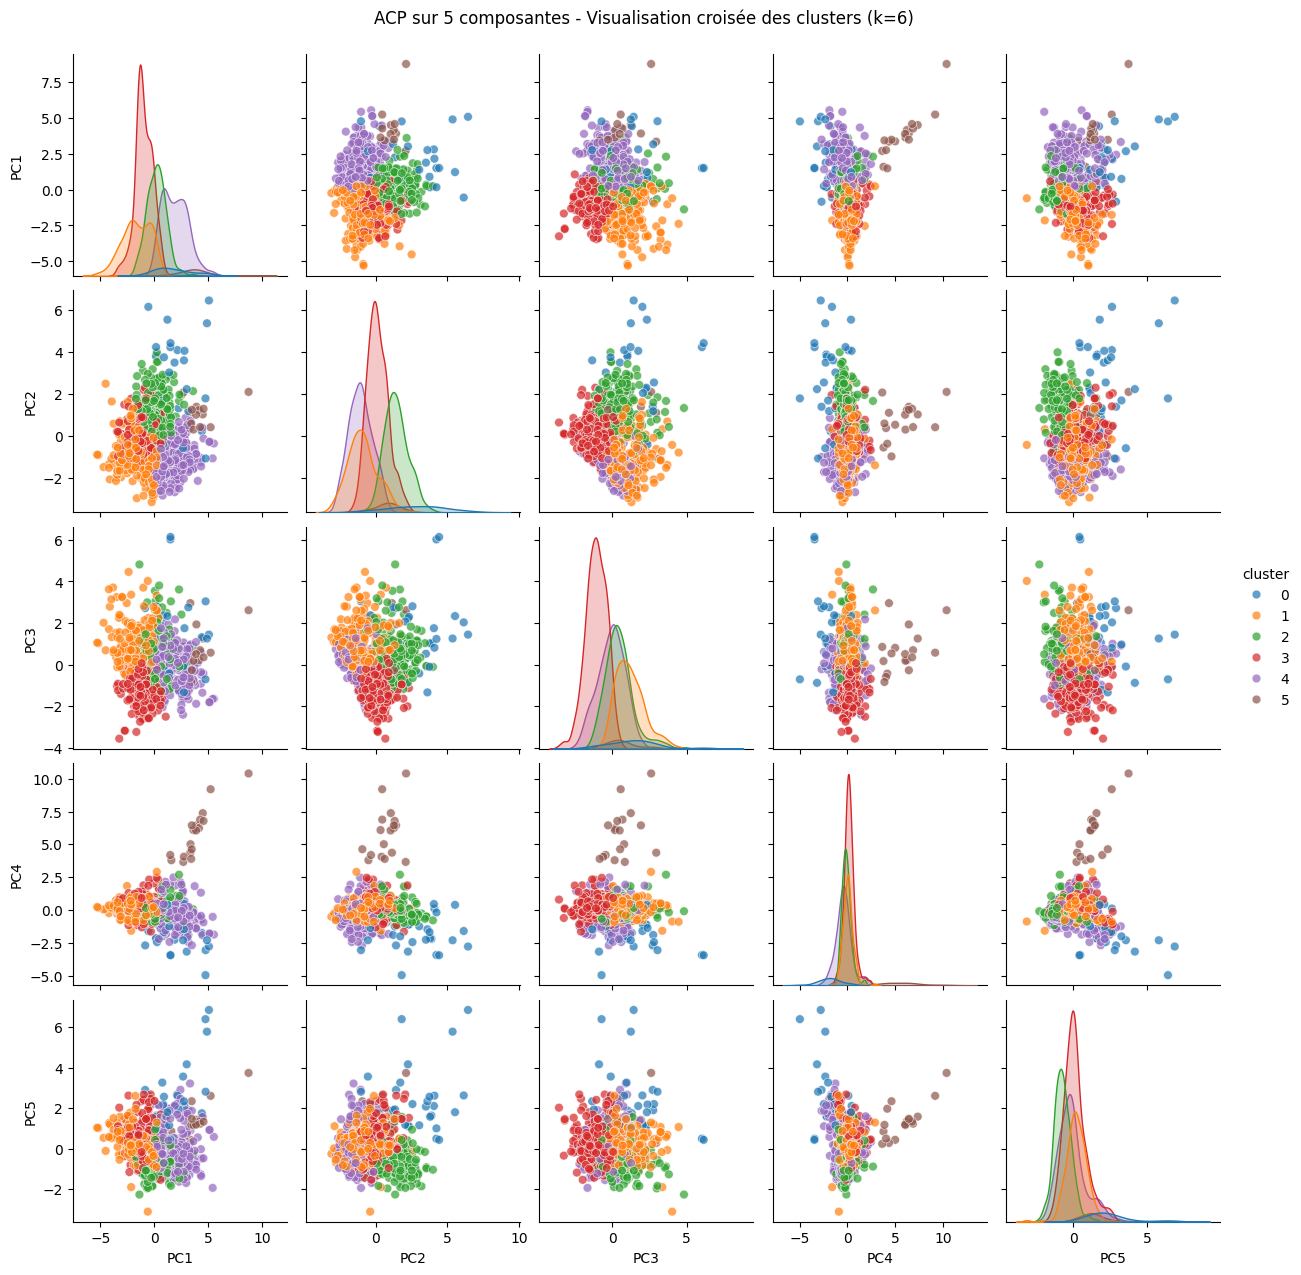

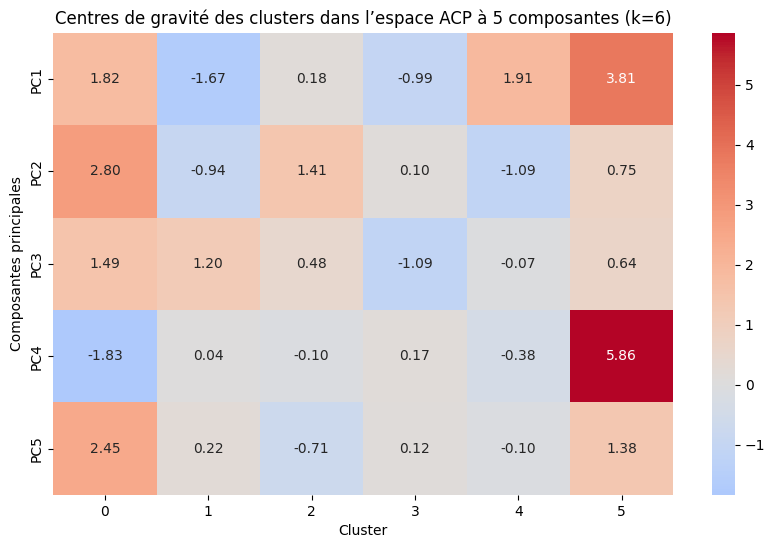

Inertie intra-classe moyenne du cluster 0 : 13.210
Inertie intra-classe moyenne du cluster 1 : 4.383
Inertie intra-classe moyenne du cluster 2 : 2.985
Inertie intra-classe moyenne du cluster 3 : 2.549
Inertie intra-classe moyenne du cluster 4 : 4.370
Inertie intra-classe moyenne du cluster 5 : 8.012

Inertie inter-classe      : 5091.66
Inertie intra-classe totale : 3880.16
Inertie totale              : 8971.82
Taux d'inertie expliquée    : 56.75%


In [272]:
# Projection PCA avec 5 composantes principales et K=6
# ACP à 5 composantes
pca_5 = PCA(n_components=5)
#!Warning: X has to be normalized
X_pca_5: pd.DataFrame = pca_5.fit_transform(X)

# K-means avec k=3
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
clusters: list[int] = kmeans.fit_predict(X_pca_5)

# Construction du dataframe pour le pairplot
df_pca_pairplot = pd.DataFrame(X_pca_5, columns=[f"PC{i+1}" for i in range(5)])
df_pca_pairplot["cluster"] = clusters

# Affichage
sns.pairplot(df_pca_pairplot, hue="cluster", palette="tab10",
             plot_kws={'alpha': 0.7, 's': 40})
plt.suptitle(
    f"ACP sur 5 composantes - Visualisation croisée des clusters (k={k})", y=1.02)
plt.show()

# Moyennes des composantes principales par cluster
df_means = df_pca_pairplot.groupby("cluster").mean()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_means.T, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(
    f"Centres de gravité des clusters dans l’espace ACP à 5 composantes (k={k})")
plt.xlabel("Cluster")
plt.ylabel("Composantes principales")
plt.show()

# Calcul de l’inertie intra-classe manuellement
inertie_clusters = []
for i in range(k):
    cluster_points = X_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    inertie = np.mean(distances ** 2)
    inertie_clusters.append(inertie)

# Affichage des inerties intra-classe par cluster
for i, inertie in enumerate(inertie_clusters):
    print(f"Inertie intra-classe moyenne du cluster {i} : {inertie:.3f}")

# Centre global
global_center = np.mean(X_pca_5, axis=0)

# Inertie inter-classe
inertie_inter = 0.0
for i in range(k):
    cluster_points = X_pca_5[clusters == i]
    centroid = cluster_points.mean(axis=0)
    nk = cluster_points.shape[0]
    inertie_inter += nk * np.sum((centroid - global_center) ** 2)

# Inertie totale
inertie_totale = np.sum(np.linalg.norm(X_pca_5 - global_center, axis=1) ** 2)

# Inertie intra totale (somme des intra par points)
inertie_intra = np.sum([np.sum(np.linalg.norm(X_pca_5[clusters == i] -
                       X_pca_5[clusters == i].mean(axis=0), axis=1) ** 2) for i in range(k)])

# Taux d'inertie expliquée
taux_explique = inertie_inter / inertie_totale

# Résultats
print(f"\nInertie inter-classe      : {inertie_inter:.2f}")
print(f"Inertie intra-classe totale : {inertie_intra:.2f}")
print(f"Inertie totale              : {inertie_totale:.2f}")
print(f"Taux d'inertie expliquée    : {taux_explique*100:.2f}%")

#### Analyse comparative du nombre de clusters (k = 3 vs k = 6)

Nous avons appliqué une ACP suivie d’un clustering K-means pour explorer la structure latente du dataset de vins rouges. Cette section compare deux partitions : k = 3 et k = 6, à l’aide des visualisations (PCA), des inerties intra/inter-classe, et de l’inertie expliquée.


**Inerties globales**

| Métrique                     | K = 3       | K = 6       |
|-----------------------------|-------------|-------------|
| Inertie inter-classe        | 2911.87     | 5091.66     |
| Inertie intra-classe totale | 6188.75     | 3880.16     |
| Inertie totale              | 9100.61     | 8971.82     |
| Taux d'inertie expliquée    | 32.00 %     | 56.75 %     |

Le taux d’inertie expliquée est nettement supérieur pour k = 6, ce qui signifie que la variance entre groupes est mieux capturée par la partition à 6 clusters. Cela respecte un critère fondamental du cours SY09 : plus ce taux est élevé, plus la classification est pertinente.


**Inertie intra-classe moyenne par cluster**

K = 3 :

| Cluster | Inertie intra-classe |
|---------|----------------------|
| 0       | 7.541                |
| 1       | 5.164                |
| 2       | 9.042                |
| Moyenne | 7.25                 |

K = 6 :

| Cluster | Inertie intra-classe |
|---------|----------------------|
| 0       | 13.210               |
| 1       | 4.383                |
| 2       | 2.985                |
| 3       | 2.549                |
| 4       | 4.370                |
| 5       | 8.012                |
| Moyenne | 5.92                 |

La moyenne d’inertie intra-classe est plus faible pour k = 6, ce qui signifie que les clusters sont globalement plus compacts. Toutefois, on observe une grande hétérogénéité : le cluster 0 est très dispersé (13.2), ce qui pénalise la qualité globale de la partition.

**Visualisation ACP**

Projection PCA à 2 composantes principales:

- Pour k = 3, les clusters sont bien séparés et forment une structure triangulaire claire dans le plan factoriel.
- Pour k = 6, les groupes sont plus nombreux mais se chevauchent fortement, ce qui rend la séparation moins lisible.

Projection ACP à 5 composantes:

- À k = 3, les clusters sont cohérents dans plusieurs plans croisés, avec des centres bien distincts.
- À k = 6, certains clusters restent proches malgré l’augmentation de dimensions, et la structure devient difficile à interpréter sans techniques avancées de visualisation.


**Résumé comparatif**

| Critère                         | k = 3                      | k = 6                              |
|----------------------------------|----------------------------|------------------------------------|
| Visualisation (ACP 2D)          | claire et lisible          | confus, recouvrement important     |
| Moyenne intra-classe            | 7.25                       | 5.92                               |
| Taux d'inertie expliquée        | 32.00 %                    | 56.75 %                            |
| Stabilité des clusters          | relativement homogène      | un cluster très diffus (0)         |
| Interprétation métier possible  | forte (faible/moyen/bon)   | plus difficile à traduire          |


**Conclusion**

Le choix de k = 3 offre un bon compromis entre qualité statistique, lisibilité des clusters et interprétation métier. Il est particulièrement adapté pour une première modélisation supervisée ou une segmentation claire.

La solution à k = 6 permet une meilleure inertie expliquée mais présente plusieurs limites :
- Un cluster très dispersé qui affaiblit la cohérence de la partition.
- Une séparation moins visible dans les plans factoriels.
- Une complexité d’interprétation plus élevée.

Ce choix dépend donc de l’objectif :

- Dans une logique de **classification supervisée** ou d’**interprétation métier simplifiée**, comme en **analyse discriminante (ADL/ADQ)** ou en **régression logistique**, il est préférable d’opter pour **k = 3**, car les classes sont plus stables, bien séparées visuellement, et facilement interprétables.

- En revanche, dans une démarche **non supervisée exploratoire**, comme dans les **méthodes de classification automatique** (CAH, K-means, profils de classes) ou de **segmentation fine**, où l’on cherche à capturer une diversité plus nuancée, **k = 6** peut être envisagé. Il sera alors utile de compléter par des méthodes d’interprétation comme des arbres de classification ou des analyses des centres de gravité pour profiler les groupes.


